In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import random
from scipy.sparse import csr_matrix

from tqdm import tqdm
from collections import defaultdict

from joblib import Parallel, delayed


from implicit.als import AlternatingLeastSquares

from catboost import *
from catboost import CatBoostClassifier

from sklearn.metrics.pairwise import cosine_similarity, paired_distances
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterGrid
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import VALID_METRICS, NearestNeighbors
from sklearn.metrics import roc_auc_score, classification_report, silhouette_score

import optuna

from tqdm.notebook import tqdm as tqdm_notebook

from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import hmean  # Для гармонического среднего

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

random.seed(42)
np.random.seed(42)

In [ ]:
  pip install numpy==1.26.4

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
pip install optuna

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
pip install implicit

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
pip install faiss-cpu

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
import faiss

# Общие комменты
- не забыть про финальную фильтрацию резов: если юзер уже смотрел фильм, то вероятно второй раз не посмотрит, если он смотрит только популярное

Задача рекомендаций фильмов пользователям на основе истории оценок.
В качестве сабмита необходимо предоставить 10 рекомендуемых фильмов для каждого пользователя (см. submission_sample.csv).

Метрика: recall@10

Для зачета домашнего задания необходимо:

Предоставить командный git репозиторий. В репозитории должна быть указана роль каждого члена команды (отмечен скрипт/часть скрипта каждого члена команды).
Метрики в репозитории должны быть воспроизводимы

In [ ]:
events = pd.read_csv('hse-rec-sys-challenge-2025/events.csv')
item_features = pd.read_csv('hse-rec-sys-challenge-2025/item_features.csv')
submission_sample = pd.read_csv('hse-rec-sys-challenge-2025/submission_sample.csv')
user_features = pd.read_csv('hse-rec-sys-challenge-2025/user_features.csv')


'''
events.csv - интеракции пользователей (история оценок)
user_features.csv - признаки пользователя
item_features.csv - признаки фильмов
submission_sample.csv - пример сабмита
Формат сабмита: user_id[str], item_id[str] - см submission_sample.csv
'''

'\nevents.csv - интеракции пользователей (история оценок)\nuser_features.csv - признаки пользователя\nitem_features.csv - признаки фильмов\nsubmission_sample.csv - пример сабмита\nФормат сабмита: user_id[str], item_id[str] - см submission_sample.csv\n'

In [ ]:
display(events.head(2), item_features.head(2), submission_sample.head(2), user_features.head(2))

,user_id,item_id,rating,timestamp
0,0,1505,4,0
1,0,3669,3,1


,item_id,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17
0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


,user_id,item_id
0,0,0 1 2 3 4 5 6 7 8 9
1,1,0 1 2 3 4 5 6 7 8 9


,user_id,gender,age
0,4855,F,1
1,4065,M,56


In [ ]:
events.groupby('user_id')['item_id'].nunique().sort_values(ascending=True)

user_id
488       14
3123      15
1943      15
4112      15
5856      15
        ... 
4018    1390
4635    1438
4285    1544
69      1675
2257    2056
Name: item_id, Length: 6040, dtype: int64

## Сделаем изначальный сплит на трейн вал тест для бустинга. Далее сплиты будут выполняться на полученной выборке трейн.

In [ ]:
# Функция для разделения данных на train, val, test (User time split)
def train_val_test_split(df, val_size=0.1, test_size=0.1):
    train_data, val_data, test_data = [], [], []

    for user in df['user_id_idx'].unique():
        user_data = df[df['user_id_idx'] == user].sort_values('timestamp')
        n = len(user_data)

        # Для вал выборке отбираем 5 фильмов, для теста - 10
        test_split = max(int(n * (1 - test_size)), (n - 10))
        val_split = max(int(test_split * (1 - val_size)), (n - 15))

        train_data.append(user_data.iloc[:val_split])
        val_data.append(user_data.iloc[val_split:test_split])
        test_data.append(user_data.iloc[test_split:])

    train_data = pd.concat(train_data)
    val_data = pd.concat(val_data)
    test_data = pd.concat(test_data)

    return train_data, val_data, test_data


# Создаем разреженные матрицы взаимодействий
def create_sparse_matrix(df, n_users, n_items):
    # строки - пользователи, столбцы - айтемы (user-item матрица)
    return csr_matrix((df['rating'], (df['user_id_idx'], df['item_id_idx'])), shape=(n_users, n_items))

In [ ]:
# Переиндексация user_id и item_id (чтобы индексы были последовательны и начинались с 0)
events['user_id_idx'], user_index = pd.factorize(events['user_id'])
events['item_id_idx'], item_index = pd.factorize(events['item_id'])


n_users_glob = events['user_id_idx'].nunique()
n_items_glob = events['item_id_idx'].nunique()
print(n_users_glob, n_items_glob)

6040 3690


In [ ]:
# Разделяем данные для catboost
train_data_glob, val_data_glob, test_data_glob = train_val_test_split(events, val_size=0.1, test_size=0.1)

not_train_data_glob = pd.concat([val_data_glob, test_data_glob], axis=0) # Выборка для последнего скоринга

In [ ]:
# Создаем разреженные матрицы взаимодействий
train_matrix_glob = create_sparse_matrix(train_data_glob, n_users_glob, n_items_glob)
val_matrix_glob = create_sparse_matrix(val_data_glob, n_users_glob, n_items_glob)
test_matrix_glob = create_sparse_matrix(test_data_glob, n_users_glob, n_items_glob)

not_train_matrix_glob = create_sparse_matrix(not_train_data_glob, n_users_glob, n_items_glob)

### Далее для обучения промежуточных моделей будем использовать выборку  **train_data_glob**

In [ ]:
all_models_df = pd.read_parquet('all_models_df_v2.parquet')

In [ ]:
all_models_df.head()

,user_id,item_id,score_als,score_item2item_NL,score_last_1_NL,score_last_2_NL,score_last_3_NL,score_last_4_NL,score_last_5_NL,score_top_pop_NL,score_genre_top_items_NL,interaction_count,average_rating,score_x,popularity_score_dumb,average_rating_dumb,kmeans_10,agg_10,dbscan,score_y,distance,flag,genre_0_x,genre_1_x,genre_2_x,genre_3_x,genre_4_x,genre_5_x,genre_6_x,genre_7_x,genre_8_x,genre_9_x,genre_10_x,genre_11_x,genre_12_x,genre_13_x,genre_14_x,genre_15_x,genre_16_x,genre_17_x,user_avg_rating,user_min_rating,user_max_rating,user_rating_count,user_rating_std,user_unique_items,user_start_time,last_user_activity,user_activity_timedelta,user_positive_items,user_unwatched_ratio,user_positive_rating_count,user_positive_rating_ratio,user_bias,rating_user_cummean,rating_user_normalized,rating_user_normalized_round,gender,age,gender_age_avg_rating,top_2_avg_rating_user,top_4_avg_rating_user,top_6_avg_rating_user,top_8_avg_rating_user,top_10_avg_rating_user,top_12_avg_rating_user,top_14_avg_rating_user,top_16_avg_rating_user,top_18_avg_rating_user,top_20_avg_rating_user,top_22_avg_rating_user,top_24_avg_rating_user,top_26_avg_rating_user,top_28_avg_rating_user,top_30_avg_rating_user,top_32_avg_rating_user,top_34_avg_rating_user,top_36_avg_rating_user,top_38_avg_rating_user,top_40_avg_rating_user,top_42_avg_rating_user,top_44_avg_rating_user,top_46_avg_rating_user,top_48_avg_rating_user,top_50_avg_rating_user,rating_user_cumsum,rating_user_cumcount,gender_age_min_rating,gender_age_max_rating,gender_age_rating_count,gender_age_unique_users,gender_age_start_time,gender_age_last_activity,gender_age_positive_items,gender_age_positive_ratio,user_gender_age_avg_rating,user_gender_age_min_rating,user_gender_age_max_rating,user_gender_age_rating_count,user_gender_age_positive_items,gender_age_rating_variance,gender_age_rating_std,overall_gender_age_avg_rating,user_gender_age_bias,top_30_avg_rating_item,top_20_avg_rating_item,user_age_item_genre_1,user_genre_pref_genre_0,user_genre_pref*genre_3,user_genre_pref*genre_16,top_34_avg_rating_item,user_genre_pref_genre_12,user_genre_pref_genre_15,user_genre_pref*genre_0,genre_8_y,item_avg_rating,user_rating_interval,user_genre_pref*genre_9,user_genre_pref_genre_4,user_genre_pref_genre_5,top_4_avg_rating_item,genre_15_user_total,genre_5_y,user_avg_genre_5,user_age_item_genre_4,user_age_item_genre_0,item_positive_rating_ratio,user_genre_pref_genre_17,top_12_avg_rating_item,user_genre_pref*genre_7,user_genre_pref*genre_17,item_min_rating,genre_10_y,item_is_single_genre,datetime,first_item_rating_time,item_olden,top_28_avg_rating_item,item_unique_users,genre_12_y,genre_13_user_total,top_42_avg_rating_item,rating_item_cumcount,has_user_seen_similar_items_before,user_age_item_genre_6,user_avg_genre_11,user_genre_pref*genre_14,user_age_item_genre_5,genre_3_y,genre_11_y,user_repeats_items_ratio,rating_delta_user,user_genre_pref_genre_9,genre_1_user_total,top_22_avg_rating_item,genre_7_y,rating_delta_item,genre_13_y,genre_7_user_total,top_36_avg_rating_item,user_genre_pref*genre_5,user_genre_pref*genre_11,user_avg_genre_4,user_avg_genre_9,user_avg_genre_15,top_2_avg_rating_item,user_avg_genre_3,user_genre_pref*genre_1,genre_14_user_total,user_rating_deviation,genre_8_user_total,user_age_item_genre_12,top_16_avg_rating_item,genre_9_user_total,user_genre_pref*genre_8,genre_0_y,genre_2_user_total,item_num_genres,item_rating_diversity,user_genre_pref*genre_15,genre_1_y,user_avg_genre_13,user_avg_genre_6,user_avg_genre_8,genre_11_user_total,rating_item_cumsum,user_age_item_genre_13,user_genre_pref_genre_1,user_avg_genre_10,genre_10_user_total,user_genre_pref_genre_7,item_max_rating,user_age_item_genre_17,genre_15_y,genre_16_user_total,user_age_item_genre_11,user_item_interaction_count,user_age_item_genre_8,user_genre_pref*genre_6,item_rating_count,user_avg_genre_1,user_age_item_genre_2,genre_14_y,user_age_item_genre_7,top_14_avg_rating_item,user_avg_genre_2,user_age_item_genre_3,user_n_items_rated_once,top_46_avg

### Сбор таргета

In [ ]:
not_train_data_glob['target'] = 1
all_models_df = all_models_df.merge(not_train_data_glob[['user_id', 'item_id', 'target']], on=['user_id', 'item_id'], how='outer')
all_models_df['target'] = all_models_df['target'].fillna(0)
all_models_df['target'].value_counts(), not_train_data_glob.shape[0]

(0.0    8691186
 1.0      71938
 Name: target, dtype: int64,
 71938)

In [ ]:
# bert_df

In [ ]:
all_models_df

,user_id,item_id,score_als,score_item2item_NL,score_last_1_NL,score_last_2_NL,score_last_3_NL,score_last_4_NL,score_last_5_NL,score_top_pop_NL,score_genre_top_items_NL,interaction_count,average_rating,score_x,popularity_score_dumb,average_rating_dumb,kmeans_10,agg_10,dbscan,score_y,distance,flag,genre_0_x,genre_1_x,genre_2_x,genre_3_x,genre_4_x,genre_5_x,genre_6_x,genre_7_x,genre_8_x,genre_9_x,genre_10_x,genre_11_x,genre_12_x,genre_13_x,genre_14_x,genre_15_x,genre_16_x,genre_17_x,user_avg_rating,user_min_rating,user_max_rating,user_rating_count,user_rating_std,user_unique_items,user_start_time,last_user_activity,user_activity_timedelta,user_positive_items,user_unwatched_ratio,user_positive_rating_count,user_positive_rating_ratio,user_bias,rating_user_cummean,rating_user_normalized,rating_user_normalized_round,gender,age,gender_age_avg_rating,top_2_avg_rating_user,top_4_avg_rating_user,top_6_avg_rating_user,top_8_avg_rating_user,top_10_avg_rating_user,top_12_avg_rating_user,top_14_avg_rating_user,top_16_avg_rating_user,top_18_avg_rating_user,top_20_avg_rating_user,top_22_avg_rating_user,top_24_avg_rating_user,top_26_avg_rating_user,top_28_avg_rating_user,top_30_avg_rating_user,top_32_avg_rating_user,top_34_avg_rating_user,top_36_avg_rating_user,top_38_avg_rating_user,top_40_avg_rating_user,top_42_avg_rating_user,top_44_avg_rating_user,top_46_avg_rating_user,top_48_avg_rating_user,top_50_avg_rating_user,rating_user_cumsum,rating_user_cumcount,gender_age_min_rating,gender_age_max_rating,gender_age_rating_count,gender_age_unique_users,gender_age_start_time,gender_age_last_activity,gender_age_positive_items,gender_age_positive_ratio,user_gender_age_avg_rating,user_gender_age_min_rating,user_gender_age_max_rating,user_gender_age_rating_count,user_gender_age_positive_items,gender_age_rating_variance,gender_age_rating_std,overall_gender_age_avg_rating,user_gender_age_bias,top_30_avg_rating_item,top_20_avg_rating_item,user_age_item_genre_1,user_genre_pref_genre_0,user_genre_pref*genre_3,user_genre_pref*genre_16,top_34_avg_rating_item,user_genre_pref_genre_12,user_genre_pref_genre_15,user_genre_pref*genre_0,genre_8_y,item_avg_rating,user_rating_interval,user_genre_pref*genre_9,user_genre_pref_genre_4,user_genre_pref_genre_5,top_4_avg_rating_item,genre_15_user_total,genre_5_y,user_avg_genre_5,user_age_item_genre_4,user_age_item_genre_0,item_positive_rating_ratio,user_genre_pref_genre_17,top_12_avg_rating_item,user_genre_pref*genre_7,user_genre_pref*genre_17,item_min_rating,genre_10_y,item_is_single_genre,datetime,first_item_rating_time,item_olden,top_28_avg_rating_item,item_unique_users,genre_12_y,genre_13_user_total,top_42_avg_rating_item,rating_item_cumcount,has_user_seen_similar_items_before,user_age_item_genre_6,user_avg_genre_11,user_genre_pref*genre_14,user_age_item_genre_5,genre_3_y,genre_11_y,user_repeats_items_ratio,rating_delta_user,user_genre_pref_genre_9,genre_1_user_total,top_22_avg_rating_item,genre_7_y,rating_delta_item,genre_13_y,genre_7_user_total,top_36_avg_rating_item,user_genre_pref*genre_5,user_genre_pref*genre_11,user_avg_genre_4,user_avg_genre_9,user_avg_genre_15,top_2_avg_rating_item,user_avg_genre_3,user_genre_pref*genre_1,genre_14_user_total,user_rating_deviation,genre_8_user_total,user_age_item_genre_12,top_16_avg_rating_item,genre_9_user_total,user_genre_pref*genre_8,genre_0_y,genre_2_user_total,item_num_genres,item_rating_diversity,user_genre_pref*genre_15,genre_1_y,user_avg_genre_13,user_avg_genre_6,user_avg_genre_8,genre_11_user_total,rating_item_cumsum,user_age_item_genre_13,user_genre_pref_genre_1,user_avg_genre_10,genre_10_user_total,user_genre_pref_genre_7,item_max_rating,user_age_item_genre_17,genre_15_y,genre_16_user_total,user_age_item_genre_11,user_item_interaction_count,user_age_item_genre_8,user_genre_pref*genre_6,item_rating_count,user_avg_genre_1,user_age_item_genre_2,genre_14_y,user_age_item_genre_7,top_14_avg_rating_item,user_avg_genre_2,user_age_item_genre_3,user_n_items_rated_once,top_46_avg

In [ ]:
f1 = (all_models_df['target'] != 1)
# f2 = (all_models_df['score_bert'].isna())
f3 = (all_models_df['score_als'].isna())
f4 = (all_models_df['score_item2item_NL'].isna())
f_all = f1 & f3 & f4 # & f2


In [ ]:
all_models_df

,user_id,item_id,score_als,score_item2item_NL,score_last_1_NL,score_last_2_NL,score_last_3_NL,score_last_4_NL,score_last_5_NL,score_top_pop_NL,score_genre_top_items_NL,interaction_count,average_rating,score_x,popularity_score_dumb,average_rating_dumb,kmeans_10,agg_10,dbscan,score_y,distance,flag,genre_0_x,genre_1_x,genre_2_x,genre_3_x,genre_4_x,genre_5_x,genre_6_x,genre_7_x,genre_8_x,genre_9_x,genre_10_x,genre_11_x,genre_12_x,genre_13_x,genre_14_x,genre_15_x,genre_16_x,genre_17_x,user_avg_rating,user_min_rating,user_max_rating,user_rating_count,user_rating_std,user_unique_items,user_start_time,last_user_activity,user_activity_timedelta,user_positive_items,user_unwatched_ratio,user_positive_rating_count,user_positive_rating_ratio,user_bias,rating_user_cummean,rating_user_normalized,rating_user_normalized_round,gender,age,gender_age_avg_rating,top_2_avg_rating_user,top_4_avg_rating_user,top_6_avg_rating_user,top_8_avg_rating_user,top_10_avg_rating_user,top_12_avg_rating_user,top_14_avg_rating_user,top_16_avg_rating_user,top_18_avg_rating_user,top_20_avg_rating_user,top_22_avg_rating_user,top_24_avg_rating_user,top_26_avg_rating_user,top_28_avg_rating_user,top_30_avg_rating_user,top_32_avg_rating_user,top_34_avg_rating_user,top_36_avg_rating_user,top_38_avg_rating_user,top_40_avg_rating_user,top_42_avg_rating_user,top_44_avg_rating_user,top_46_avg_rating_user,top_48_avg_rating_user,top_50_avg_rating_user,rating_user_cumsum,rating_user_cumcount,gender_age_min_rating,gender_age_max_rating,gender_age_rating_count,gender_age_unique_users,gender_age_start_time,gender_age_last_activity,gender_age_positive_items,gender_age_positive_ratio,user_gender_age_avg_rating,user_gender_age_min_rating,user_gender_age_max_rating,user_gender_age_rating_count,user_gender_age_positive_items,gender_age_rating_variance,gender_age_rating_std,overall_gender_age_avg_rating,user_gender_age_bias,top_30_avg_rating_item,top_20_avg_rating_item,user_age_item_genre_1,user_genre_pref_genre_0,user_genre_pref*genre_3,user_genre_pref*genre_16,top_34_avg_rating_item,user_genre_pref_genre_12,user_genre_pref_genre_15,user_genre_pref*genre_0,genre_8_y,item_avg_rating,user_rating_interval,user_genre_pref*genre_9,user_genre_pref_genre_4,user_genre_pref_genre_5,top_4_avg_rating_item,genre_15_user_total,genre_5_y,user_avg_genre_5,user_age_item_genre_4,user_age_item_genre_0,item_positive_rating_ratio,user_genre_pref_genre_17,top_12_avg_rating_item,user_genre_pref*genre_7,user_genre_pref*genre_17,item_min_rating,genre_10_y,item_is_single_genre,datetime,first_item_rating_time,item_olden,top_28_avg_rating_item,item_unique_users,genre_12_y,genre_13_user_total,top_42_avg_rating_item,rating_item_cumcount,has_user_seen_similar_items_before,user_age_item_genre_6,user_avg_genre_11,user_genre_pref*genre_14,user_age_item_genre_5,genre_3_y,genre_11_y,user_repeats_items_ratio,rating_delta_user,user_genre_pref_genre_9,genre_1_user_total,top_22_avg_rating_item,genre_7_y,rating_delta_item,genre_13_y,genre_7_user_total,top_36_avg_rating_item,user_genre_pref*genre_5,user_genre_pref*genre_11,user_avg_genre_4,user_avg_genre_9,user_avg_genre_15,top_2_avg_rating_item,user_avg_genre_3,user_genre_pref*genre_1,genre_14_user_total,user_rating_deviation,genre_8_user_total,user_age_item_genre_12,top_16_avg_rating_item,genre_9_user_total,user_genre_pref*genre_8,genre_0_y,genre_2_user_total,item_num_genres,item_rating_diversity,user_genre_pref*genre_15,genre_1_y,user_avg_genre_13,user_avg_genre_6,user_avg_genre_8,genre_11_user_total,rating_item_cumsum,user_age_item_genre_13,user_genre_pref_genre_1,user_avg_genre_10,genre_10_user_total,user_genre_pref_genre_7,item_max_rating,user_age_item_genre_17,genre_15_y,genre_16_user_total,user_age_item_genre_11,user_item_interaction_count,user_age_item_genre_8,user_genre_pref*genre_6,item_rating_count,user_avg_genre_1,user_age_item_genre_2,genre_14_y,user_age_item_genre_7,top_14_avg_rating_item,user_avg_genre_2,user_age_item_genre_3,user_n_items_rated_once,top_46_avg

In [ ]:
# all_models_df = all_models_df[~f_all]

In [ ]:
all_models_df['target'].mean()

0.008209172893137197

In [ ]:
all_models_df = all_models_df.fillna(-999)

# all_models_df[['score_l2', 'score_ip', 'score_total']] = all_models_df[['score_l2', 'score_ip', 'score_total']].replace(-1, -999)

print(all_models_df.shape)

(8763124, 275)


In [ ]:
def train_val_test_split(X, y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    # Проверяем, что размеры разделения корректны
    assert train_size + val_size + test_size == 1, "Сумма размеров должна быть равна 1"

    # Первое разделение: train и временный (вал+тест)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), random_state=random_state)

    # Второе разделение: вал+тест разбивается на вал и тест
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (test_size + val_size), random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(all_models_df.drop(['user_id', 'item_id','target'], axis=1), all_models_df['target'])

## Обучение реранжирующего бустинга

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
%pip install optuna-integration[catboost]

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss

# --- убираем datetime/timedelta и дата-строки, выравниваем признаки ---
def _drop_dt_td_and_align(X_train, X_val):
    X_train = X_train.copy()
    X_val   = X_val.copy()

    # 1) явные datetime и timedelta
    dt_tr = set(X_train.select_dtypes(include=['datetime', 'datetimetz']).columns)
    dt_va = set(X_val.select_dtypes(include=['datetime', 'datetimetz']).columns)
    td_tr = set(X_train.select_dtypes(include=['timedelta']).columns)
    td_va = set(X_val.select_dtypes(include=['timedelta']).columns)
    drop_cols = set().union(dt_tr, dt_va, td_tr, td_va)

    # 2) object-колонки, которые по факту даты (>=50% парсятся как дата)
    def _dt_like(df):
        cols = []
        for c in df.select_dtypes(include=['object']).columns:
            s = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=True)
            if s.notna().mean() > 0.5:
                cols.append(c)
        return set(cols)

    drop_cols |= _dt_like(X_train)
    drop_cols |= _dt_like(X_val)

    if drop_cols:
        X_train.drop(columns=list(drop_cols), inplace=True, errors='ignore')
        X_val.drop(columns=list(drop_cols), inplace=True, errors='ignore')

    # 3) выравниваем состав и порядок признаков
    common = sorted(set(X_train.columns) & set(X_val.columns))
    X_train = X_train[common]
    X_val   = X_val[common]
    return X_train, X_val

# --- индексы категориальных фичей (object/category) ---
def _cat_feature_indices(df: pd.DataFrame):
    idx = []
    for i, c in enumerate(df.columns):
        if df[c].dtype == "object" or pd.api.types.is_categorical_dtype(df[c]):
            idx.append(i)
    return idx

# === подготовка ===
X_train, X_val = _drop_dt_td_and_align(X_train, X_val)
cat_idx = _cat_feature_indices(X_train)

# === "дефолтный" CatBoost без Optuna ===
model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="Logloss",
    iterations=2000,
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3.0,
    bootstrap_type="Bayesian",
    bagging_temperature=1.0,
    random_seed=42,
    verbose=100,
    allow_writing_files=False,
    task_type="CPU",   # при необходимости: "GPU"
)

model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    cat_features=cat_idx if len(cat_idx) > 0 else None,
    early_stopping_rounds=100,
    verbose=100,
)

# === метрика на валидации ===
y_pred = model.predict_proba(X_val)[:, 1]
print("Validation Logloss:", log_loss(y_val, y_pred))
print("Best iteration:", model.get_best_iteration())
print("Best scores:", model.get_best_score())


0:	learn: 0.4537244	test: 0.4537846	best: 0.4537846 (0)	total: 338ms	remaining: 11m 14s
100:	learn: 0.0000005	test: 0.0000024	best: 0.0000024 (84)	total: 30.2s	remaining: 9m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.365517409e-06
bestIteration = 84

Shrink model to first 85 iterations.
Validation Logloss: 2.3655174094660786e-06
Best iteration: 84
Best scores: {'learn': {'Logloss': 4.63438399688975e-07}, 'validation': {'Logloss': 2.3655174094653633e-06}}


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   8691186
         1.0       1.00      1.00      1.00     71938

    accuracy                           1.00   8763124
   macro avg       1.00      1.00      1.00   8763124
weighted avg       1.00      1.00      1.00   8763124



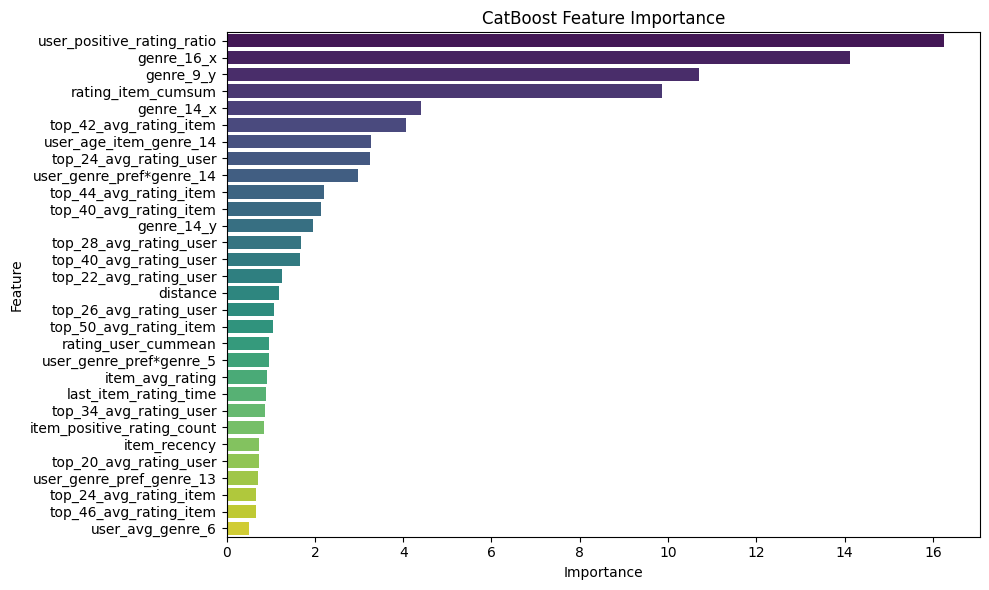

(8763124, 276)
(8763124, 276)
Количество пересечений: 53642
Пересечения:
         user_id  item_id_x  item_id_y
2720           0       2239       2239
2731           0       2931       2931
2742           0       1795       1795
2753           0       2568       2568
2764           0       1533       1533
...          ...        ...        ...
8941395     6039       3418       3418
8941406     6039        798        798
8941417     6039       2580       2580
8941428     6039        494        494
8941439     6039       2510       2510

[53642 rows x 3 columns]


In [ ]:
# --- ЗАМЕНИ ЭТИМ БЛОКОМ свой кусок со study.best_trial.params ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# 1) берём сырые фичи
X_full_raw = all_models_df.drop(['user_id', 'item_id', 'target'], axis=1)

# 2) чистим datetime/timedelta и дата-строки ИСПОЛЬЗУЯ ТВОЮ ЖЕ ФУНКЦИЮ
#    трюк: подаём один и тот же df дважды, чтобы удалить нежелательные типы
X_full_clean, _ = _drop_dt_td_and_align(X_full_raw, X_full_raw)

# 3) жёстко выравниваем под обучающие фичи:
#    - порядок ровно как в X_train.columns
#    - отсутствующие фичи заполняем 0
#    - лишние фичи отбрасываем
X_fit = X_full_clean.reindex(columns=X_train.columns, fill_value=0)

# 4) используем обученную модель из твоего нижнего кода
final_catboost = model  # чтобы ниже твои имена не ломались

# 5) инференс
result_pred = final_catboost.predict_proba(X_fit)[:, 1]
result_pred_tresh = np.where(result_pred > 0.1, 1, 0)

print(classification_report(all_models_df['target'], result_pred_tresh))

# 6) важности признаков по тем же фичам, которыми учились
feature_importances = final_catboost.get_feature_importance()
features = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).head(30)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('CatBoost Feature Importance')
plt.tight_layout()
plt.show()

# 7) приклеиваем скор в исходный df
all_models_df = all_models_df.copy()
all_models_df['result_pred'] = result_pred

# 8) исключаем обучающие события
events_merge = events.copy()
events_merge['flag'] = 1
all_models_df = all_models_df.merge(events_merge[['user_id', 'item_id', 'flag']], how='left')
print(all_models_df.shape)
all_models_df = all_models_df[all_models_df['flag'] != 1]
print(all_models_df.shape)

# 9) берём топ-10 item по каждому пользователю
submit_res = (all_models_df[['user_id', 'item_id', 'result_pred']]
              .sort_values(['user_id', 'result_pred'], ascending=[True, False])
              .groupby('user_id')[['user_id','item_id']].head(10)
              .reset_index(drop=True))

# 10) проверка пересечений с исходными событиями
merged_df = events[['user_id', 'item_id']].merge(
    submit_res[['user_id', 'item_id']], on='user_id', suffixes=('_x','_y')
)
mask = merged_df['item_id_x'] == merged_df['item_id_y']
intersections = merged_df[mask]
print(f"Количество пересечений: {len(intersections)}")
print("Пересечения:")
print(intersections)

# 11) финальный сабмит
submit_res = submit_res.groupby('user_id')['item_id'].apply(lambda x: ' '.join(map(str, x))).reset_index()
submit_res['user_id'] = submit_res['user_id'].astype(str)
submit_res.to_csv('my_new_submit.csv', index=False)
